In [1]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


The number of classes in the dataset is: 5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     


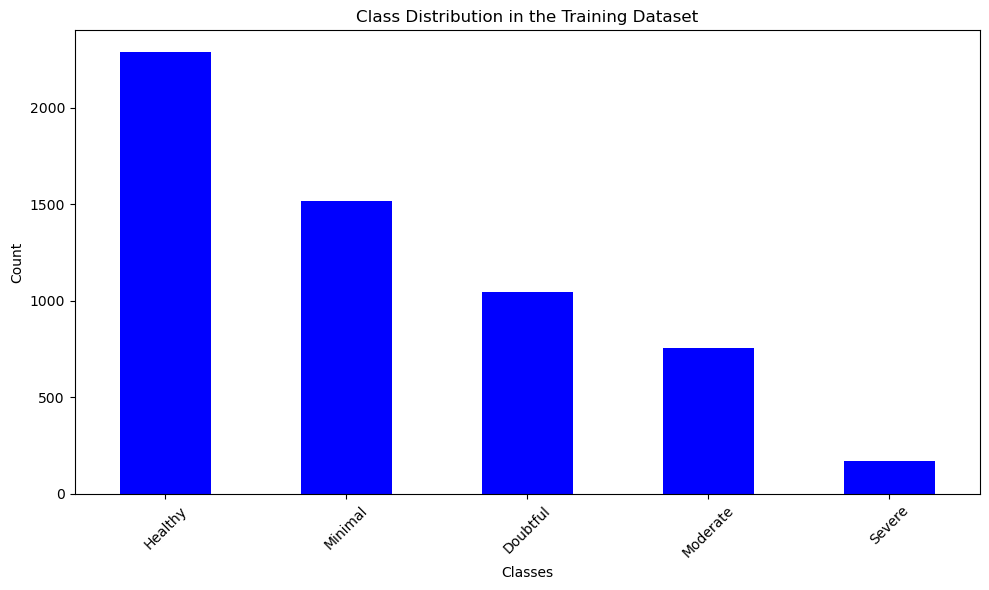

In [2]:
# Notebook 1: Data Loading and Preparation/Data Analysis and Trimming
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tensorflow import keras


# Define the paths and classes
train_path = r"C:\Users\Admin8\Desktop\NTU\Project\kneedataset\train"
test_path = r"C:\Users\Admin8\Desktop\NTU\Project\kneedataset\test"
valid_path = r"C:\Users\Admin8\Desktop\NTU\Project\kneedataset\val"
list_of_classes = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

# Load and organize the dataset
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels = []
    classlist = os.listdir(d)
    
    for klass in classlist:
        intklass = int(klass)
        label = list_of_classes[intklass]
        classpath = os.path.join(d, klass)
        flist = os.listdir(classpath)
        
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(label)
    
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    pdf = pd.concat([Fseries, Lseries], axis=1)
    
    if d == test_path:
        test_df = pdf
    elif d == valid_path:
        valid_df = pdf
    else:
        train_df = pdf
  # Display class distribution and analyze images
print('The number of classes in the dataset is:', len(list_of_classes))

groups = train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist = []
classlist = []
 # Calculate and display the image count for each class
for label in sorted(list(train_df['labels'].unique())):
    group = groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13d}'.format(label, len(group)))  
    

# Calculate the count of each class in the train_df DataFrame
class_counts = train_df['labels'].value_counts()

# Plot a bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='blue')
plt.title('Class Distribution in the Training Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the bar chart
plt.show()



In [3]:
# Find the classes with the maximum and minimum number of train images
max_value = max(countlist)
max_index = countlist.index(max_value)
max_class = classlist[max_index]
min_value = min(countlist)
min_index = countlist.index(min_value)
min_class = classlist[min_index]

print(max_class, 'has the most images =', max_value)
print(min_class, 'has the least images =', min_value)

# Calculate the average height and width of a sample of the train images
total_height = 0
total_width = 0
num_samples = 100  # Number of samples to analyze

# Select a random sample of train_df for analysis
train_df_sample = train_df.sample(n=num_samples, random_state=123, axis=0)

for i in range(len(train_df_sample)):
    fpath = train_df_sample['filepaths'].iloc[i]
    img = plt.imread(fpath)
    shape = img.shape
    total_height += shape[0]
    total_width += shape[1]

average_height = total_height // num_samples
average_width = total_width // num_samples
aspect_ratio = total_height / total_width

print('Average height =', average_height, ', Average width =', average_width, ', Aspect ratio =', aspect_ratio)


# Perform train-validation-test split on image filepaths and labels
# Save train_df, valid_df, test_df as pandas DataFrames



Healthy has the most images = 2286
Severe has the least images = 173
Average height = 224 , Average width = 224 , Aspect ratio = 1.0


In [4]:
# Combine train_df and valid_df for initial split
train_valid_df = pd.concat([train_df, valid_df], ignore_index=True)

# Perform initial train-validation split
train_filepaths, valid_filepaths, train_labels, valid_labels = train_test_split(
    train_valid_df['filepaths'], train_valid_df['labels'], test_size=0.2, random_state=123
)

# Further split the test_df for validation and test sets
valid_filepaths, test_filepaths, valid_labels, test_labels = train_test_split(
    test_df['filepaths'], test_df['labels'], test_size=0.5, random_state=123
)


In [5]:
# Remove specific classes
drop_classes = ['Minimal', 'Doubtful']
train_df = train_df[~train_df['labels'].isin(drop_classes)]
valid_df = valid_df[~valid_df['labels'].isin(drop_classes)]
test_df = test_df[~test_df['labels'].isin(drop_classes)]
# Update the list of classes
list_of_classes = [c for c in list_of_classes if c not in drop_classes]
# Re-calculate the total classes
class_count = len(list_of_classes)

# Re-count the images per class
groups = train_df.groupby('labels')
for label in list_of_classes:
    group = groups.get_group(label)
    print(label, len(group))
    
# Define a function to trim dataset samples per class
def trim(df, max_samples, min_samples, column):
    df = df.copy()
    groups = df.groupby(column)
    trimmed_df = pd.DataFrame(columns=df.columns)
    
    for label in df[column].unique():
        group = groups.get_group(label)
        count = len(group)
        
        if count > max_samples:
            sampled_group = group.sample(n=max_samples, random_state=123, axis=0)
            trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count >= min_samples:
                sampled_group = group
                trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)
    
    print('After trimming, the maximum samples in any class is now', max_samples,
          'and the minimum samples in any class is', min_samples)
    return trimmed_df

max_samples = 500  # Trim classes to have 500 samples each
min_samples = 173
column = 'labels'
train_df = trim(train_df, max_samples, min_samples, column)


Healthy 2286
Moderate 757
Severe 173
After trimming, the maximum samples in any class is now 500 and the minimum samples in any class is 173


In [6]:
# Create new DataFrames for train, valid, and test sets
train_split_df = pd.DataFrame({'filepaths': train_filepaths, 'labels': train_labels})
valid_split_df = pd.DataFrame({'filepaths': valid_filepaths, 'labels': valid_labels})
test_split_df = pd.DataFrame({'filepaths': test_filepaths, 'labels': test_labels})

# Save the new DataFrames as CSV files
train_split_df.to_csv('train_split_df.csv', index=False)
valid_split_df.to_csv('valid_split_df.csv', index=False)
test_split_df.to_csv('test_split_df.csv', index=False)


In [7]:

# Define a function to balance dataset samples per class with augmentation
def balance(df, n, working_dir, img_size):
    df = df.copy()
    print('Initial length of dataframe is', len(df))
    aug_dir = os.path.join(working_dir, 'aug')  # Directory to store augmented images
    
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)  # Remove existing directory
    os.mkdir(aug_dir)
    
    for label in df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)  # Make class directories within aug directory
    
    total = 0
    gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=.2,
                             height_shift_range=.2, zoom_range=.2)
    
    groups = df.groupby('labels')  # Group by class
    for label in df['labels'].unique():  # For every class
        group = groups.get_group(label)  # Get rows with specified label
        sample_count = len(group)  # Determine number of samples in this class
        
        if sample_count < n:  # If the class has less than target number of images
            aug_img_count = 0
            delta = n - sample_count  # Number of augmented images to create
            target_dir = os.path.join(aug_dir, label)  # Define where to save the images
            
            msg = '{0:40s} For class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='')  # Print progress on the same line 
            aug_gen = gen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=img_size,
                                              class_mode=None, batch_size=1, shuffle=False,
                                              save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                              save_format='jpg')
            
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            
            total += aug_img_count
    
    print('Total Augmented images created =', total)
  # Create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths = []
    aug_labels = []
    classlist = os.listdir(aug_dir)  
    
    for klass in classlist:
        classpath = os.path.join(aug_dir, klass)
        flist = os.listdir(classpath)
        
        for f in flist:
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    
    Fseries = pd.Series(aug_fpaths, name='filepaths')
    Lseries = pd.Series(aug_labels, name='labels')
    aug_df = pd.concat([Fseries, Lseries], axis=1)
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now', len(df))
    
    return df

# Define image size and batch size
img_size = (224, 224)  # Update with the desired image size
batch_size = 32

# Define data generators for training, validation, and testing
trgen = ImageDataGenerator(horizontal_flip=True, rotation_range=20)
t_and_v_gen = ImageDataGenerator()

train_gen = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                            class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length + 1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)

test_gen = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                           class_mode='categorical', color_mode='rgb', shuffle=False,
                                           batch_size=test_batch_size)



Found 1173 validated image filenames belonging to 3 classes.
Found 461 validated image filenames belonging to 3 classes.
Found 913 validated image filenames belonging to 3 classes.


test batch size: 11   test steps: 83  number of classes: 3


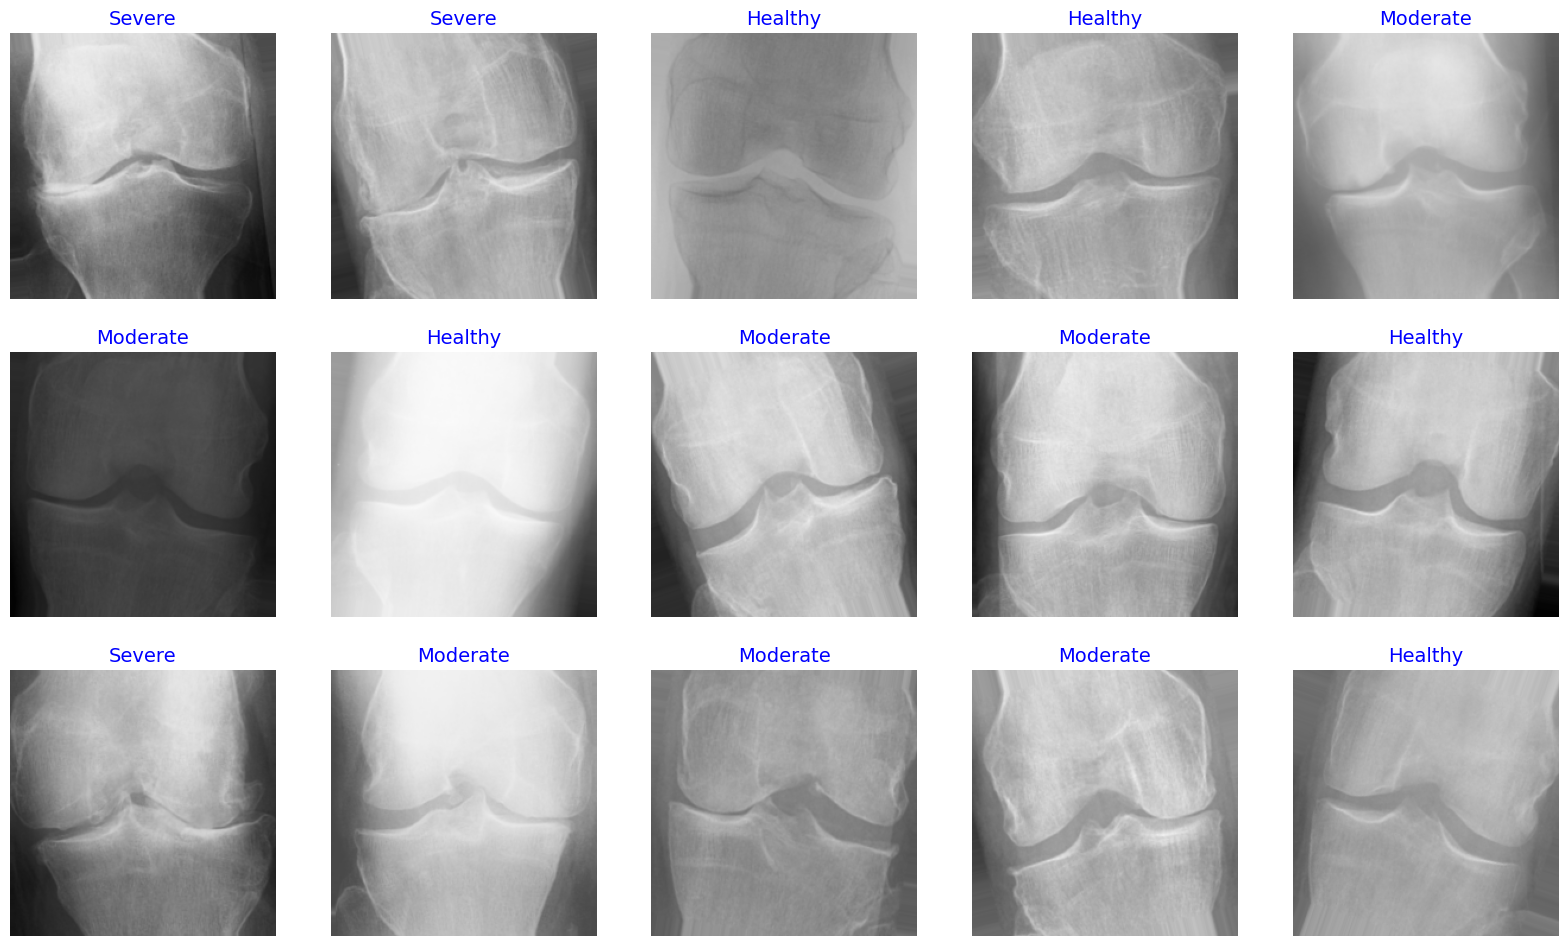

In [8]:
# Get class information from the generator
classes = list(train_gen.class_indices.keys())
class_count = len(classes)
labels = test_gen.labels

print('test batch size:', test_batch_size, '  test steps:', test_steps, ' number of classes:', class_count)


def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images, labels = next(gen)
    
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 15)  # Show maximum of 15 images
    
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    
    plt.show()

# Display image samples from the train generator
show_image_samples(train_gen)

In [9]:
# Save the modified train_df DataFrame
train_df.to_csv('augmented_train_df.csv', index=False)

In [10]:
# Load train_df, valid_df, and test_df from CSV files
#train_df = pd.read_csv(r"C:\Users\Admin8\Desktop\NTU\Project\ProjectCode\augmented_train_df.csv")
#valid_df = pd.read_csv(r"C:\Users\Admin8\Desktop\NTU\Project\ProjectCode\valid_split_df.csv")
#test_df = pd.read_csv(r"C:\Users\Admin8\Desktop\NTU\Project\ProjectCode\test_split_df.csv")
